In [145]:
# import libraries
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from skimage.segmentation import find_boundaries
from scipy.special import ellipe
from glob import glob

warnings.filterwarnings('ignore')
%matplotlib inline

#### Data Directory
> training_set

>> xyz_nHC.png (image)

>> xyz_nHC_Annotation.png (annotation/mask)

> training_set_pixel_size_and_HC.csv (pixel values for each given image)

In [12]:
# define data directory
data_dir = "../data/fetalHC/"

In [13]:
# get images and mask
images = sorted(glob(f"{data_dir}training_set/*" "C.png"))
masks = sorted(glob(f"{data_dir}training_set/*" "_Annotation.png"))

# check if both lengths are same
assert (len(images) == len(masks))

# sanity check
images[5], masks[5]

('../data/fetalHC/training_set/005_HC.png',
 '../data/fetalHC/training_set/005_HC_Annotation.png')

In [14]:
# read data pixel_size csv
pixel_values = pd.read_csv(f"{data_dir}training_set_pixel_size_and_HC.csv")

pixel_values.head(3)

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75


In [70]:
# read image and mask
image = cv2.imread(images[10])

mask = cv2.imread(masks[10])

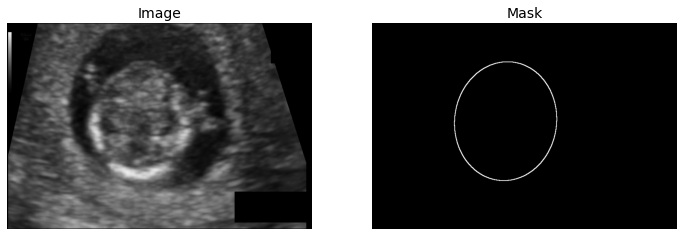

In [71]:
# view images

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(image, cmap="binary_r")
ax1.set_axis_off()
ax1.set_title('Image', fontsize=14)

ax2.imshow(mask, cmap="binary_r")
ax2.set_axis_off()
ax2.set_title('Mask', fontsize=14)

plt.show()

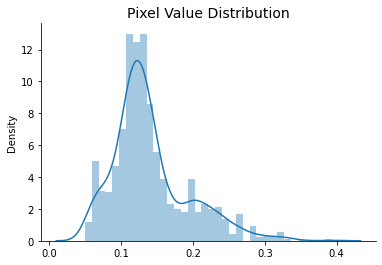

In [72]:
# check distribution of pixels given
plt.title('Pixel Value Distribution', fontdict={'fontsize': 14})
sns.distplot(pixel_values.iloc[:, 1].values)
sns.despine()
plt.show()

**From the distribution we can observe that the pixel size are ranging from 0.05 to 0.33 mm**

### Fit Ellipse

In [134]:
# get ellipse contours
copy_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

contours = cv2.findContours(mask_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

for cnt in contours:
    ellipse = cv2.fitEllipse(cnt) # fit ellipse
    cv2.ellipse(copy_mask, ellipse, (255, 255, 255), -1, cv2.LINE_AA)

copy_mask = cv2.cvtColor(copy_mask, cv2.COLOR_GRAY2RGB)
copy_mask[:, :, [0, 1]] = 0 # fill mask with blue for higlighting the region

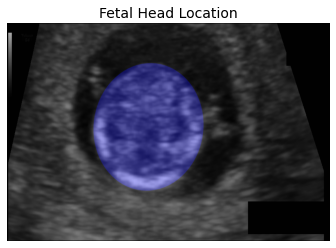

In [198]:
alpha = 0.7

fetal_head = cv2.addWeighted(copy_image, alpha , copy_mask, 1-alpha, 1)

plt.title('Fetal Head Location', fontdict={'fontsize': 14})
plt.imshow(fetal_head)
plt.axis("off")
plt.show()

In [143]:
# from fit ellipse get parameters
(xc, yc), (ma, Ma), theta = ellipse
print(f"xc: {xc}\nyc: {yc}\nminor axis: {ma}\nmajor axis: {Ma}\ntheta: {theta}")

xc: 349.9820251464844
yc: 256.842529296875
minor axis: 270.7699890136719
major axis: 315.4476318359375
theta: 7.004216194152832


In [179]:
# get a and b values
a_ = (Ma/2)
b_ = (ma/2)

# eccentricity squared
e_sq = 1.0 - b_**2/a_**2

# circumference formula
C = 4 * a_ * ellipe(e_sq)

a_, b_, C

(157.72381591796875, 135.38499450683594, 922.1661259530915)

In [180]:
# get image used
image_id = images[10].split("/")[-1]
image_id

'010_2HC.png'

In [181]:
# pixel size and ground truth
pixel_size = pixel_values[pixel_values['filename'] == image_id].iloc[:, 1].values[0]
HC_g = pixel_values[pixel_values['filename'] == image_id].iloc[:, 2].values[0]

pixel_size, true_value

(0.07992724577589999, 72.87)

In [182]:
# finding circumference
HC_p = C * pixel_size
HC_p

73.7061985952623

In [183]:
# Absolute difference (ADF)
ADF = abs(HC_p - HC_g)
ADF

0.8361985952622888

## weight map
weight map to improved the boundary detection

In [184]:
def weight_map(masks, w0=30, sigma=10):
    # ref: http://jaidevd.com/posts/weighted-loss-functions-for-instance-segmentation/
    
    nrows, ncols = masks.shape[1:]
    masks = (masks > 0).astype(int)
    distMap = np.zeros((nrows * ncols, masks.shape[0]))
    X1, Y1 = np.meshgrid(np.arange(nrows), np.arange(ncols))
    X1, Y1 = np.c_[X1.ravel(), Y1.ravel()].T
    for i, mask in enumerate(masks):
        # find the boundary of each mask,
        # compute the distance of each pixel from this boundary
        bounds = find_boundaries(mask, mode='inner')
        X2, Y2 = np.nonzero(bounds)
        xSum = (X2.reshape(-1, 1) - X1.reshape(1, -1)) ** 2
        ySum = (Y2.reshape(-1, 1) - Y1.reshape(1, -1)) ** 2
        distMap[:, i] = np.sqrt(xSum + ySum).min(axis=0)
    ix = np.arange(distMap.shape[0])
    if distMap.shape[1] == 1:
        d1 = distMap.ravel()
        border_loss_map = w0 * np.exp((-1 * (d1) ** 2) / (2 * (sigma ** 2)))
    else:
        if distMap.shape[1] == 2:
            d1_ix, d2_ix = np.argpartition(distMap, 1, axis=1)[:, :2].T
        else:
            d1_ix, d2_ix = np.argpartition(distMap, 2, axis=1)[:, :2].T
        d1 = distMap[ix, d1_ix]
        d2 = distMap[ix, d2_ix]
        border_loss_map = w0 * np.exp((-1 * (d1 + d2) ** 2) / (2 * (sigma ** 2)))
    xBLoss = np.zeros((nrows, ncols))
    xBLoss[X1, Y1] = border_loss_map

    # class weight map
    loss = np.zeros((nrows, ncols))
    w_1 = 1 - masks.sum() / loss.size
    w_0 = 1 - w_1
    loss[masks.sum(0) == 1] = w_1
    loss[masks.sum(0) == 0] = w_0
    ZZ = xBLoss + loss

    return ZZ

In [191]:
binary_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
binary_mask = np.expand_dims(binary_mask, 0)
w_x = weight_map(binary_mask)

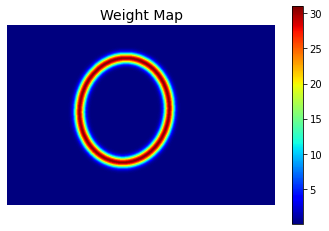

In [196]:
plt.title('Weight Map', fontdict={'fontsize': 14})
cbar = plt.imshow(w_x, cmap="jet")
plt.colorbar(cbar)
plt.axis("off")
plt.show()

from the weight map above the gradients near the boundaries are high compare to others this will help us improve for better segmentation